In [2]:
#The model is refrenced from ths papaer-the https://arxiv.org/abs/1503.08895
import pickle
import numpy as np
import tensorflow as tf

In [3]:
tf.__version__

'2.1.0'

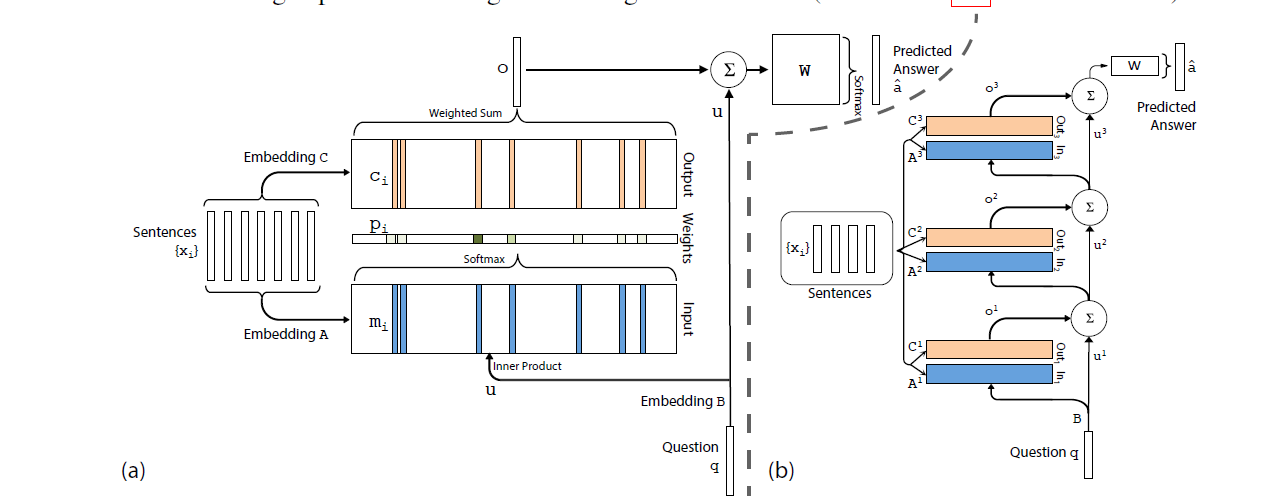

In [4]:
#load data
with open ('train_qa.txt','rb') as fp:
    train_data=pickle.load(fp)
with open('test_qa.txt','rb')as fp:
    test_data=pickle.load(fp)

In [5]:
#Explore data
print(type(train_data))
print(type(test_data))
print(len(train_data))
print(len(test_data))     

<class 'list'>
<class 'list'>
10000
1000


In [6]:
train_data[0]#[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [7]:
' '.join(train_data[0][0])

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [8]:
' '.join(train_data[0][1])

'Is Sandra in the hallway ?'

In [9]:
''.join(train_data[0][2])

'no'

In [10]:
#creating the vocalulary of words
vocab=set()#set is used so that we have unique words
all_data=train_data+test_data

In [11]:
for story,question,answer in all_data:
    vocab=vocab.union(set(story))
    vocab=vocab.union(set(question))
vocab.add('yes')
vocab.add('no')

In [12]:
vocab_len=len(vocab)+1# extra space  in case we need to pad with zero
print(vocab_len)

38


In [13]:
max_story_len= max( len(data[0]) for data in all_data)#data[0] for story
print(max_story_len)

156


In [14]:
max_question_len=max( len(data[1]) for data in all_data)#data[1] for question
print(max_question_len)

6


In [15]:
#vectorizing the data
vocab_size=vocab_len
print(vocab_size)

38


In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [17]:
#encode each word into a integer
tokenizer=Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)
tokenizer#it gives dictionay of words and integer assigned to them

In [18]:
tokenizer.word_index
#tokenizer.word_index['bedroom']

{'journeyed': 1,
 'grabbed': 2,
 'garden': 3,
 'picked': 4,
 'put': 5,
 'in': 6,
 'dropped': 7,
 'moved': 8,
 'milk': 9,
 'left': 10,
 'hallway': 11,
 'daniel': 12,
 'mary': 13,
 'bedroom': 14,
 'up': 15,
 'is': 16,
 'took': 17,
 'football': 18,
 'yes': 19,
 'went': 20,
 'john': 21,
 'discarded': 22,
 '.': 23,
 'got': 24,
 'there': 25,
 'no': 26,
 'back': 27,
 'apple': 28,
 'travelled': 29,
 'bathroom': 30,
 'the': 31,
 'kitchen': 32,
 'to': 33,
 '?': 34,
 'down': 35,
 'office': 36,
 'sandra': 37}

In [19]:
train_story_text=[]
train_question_text=[]
train_answer_text=[]
for story,question,answer in train_data:
    train_story_text.append(story)#every story will be a element in the list
    train_question_text.append(question)#every question will be a element in the list

In [20]:
train_story_seq=tokenizer.texts_to_sequences(train_story_text)#coverting each story word to the integers  as per the tokenizer
#above and indexing in word vocab
train_story_seq[0]


[13, 8, 33, 31, 30, 23, 37, 1, 33, 31, 14, 23]

In [21]:
text_t1=tokenizer.sequences_to_texts(train_story_seq)#coverting each story inetgers  to the words  as per the tokenizer above
text_t1[999]

'mary went to the bathroom . john took the milk there . sandra moved to the office . john dropped the milk . mary went to the office . daniel journeyed to the bathroom . mary journeyed to the hallway . sandra went to the bathroom . sandra travelled to the kitchen . daniel picked up the apple there .'

In [22]:
print(len(train_story_text))#10000 story we have in train_story, each story as a element in train_story_text. last idex will be 999
print(len(train_story_seq))

10000
10000


In [23]:
word_index=tokenizer.word_index
story=['Bedroom','THE','Bedroom']
x= [word_index[word.lower()] for word in story]
print(x)
y = np.zeros(len(word_index) + 1)
print(y.shape)
answer='yes'
Y=[]
y[word_index[answer]] = 1
Y.append(y)
answer='no'
y[word_index[answer]] = 1
Y.append(y)
print(Y)


[14, 31, 14]
(38,)
[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])]


In [24]:
#we have to vectorize these sequences now
def vectorize_stories(data,word_index=tokenizer.word_index,max_story_len=max_story_len,max_question_len=max_question_len):
    
    X=[]#story
    Xq=[]#question
    Y=[]#answer
    
    for story,question,answer in data:
        x= [word_index[word.lower()] for word in story]#word index for every word in story
        xq=[word_index[word.lower()] for word in question]##word index for every word in question
        
        # Grab the Answers (either Yes/No so we don't need to use list comprehension here)
        # Index 0 is reserved so we're going to use + 1
        
        y=np.zeros(len(word_index)+1)
        
        # Now that y is all zeros and we know its just Yes/No , we can use numpy logic to create this assignment
        y[word_index[answer]]=1
        
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
    return (pad_sequences(X,maxlen=max_story_len),pad_sequences(Xq,maxlen=max_question_len),np.array(Y))
#padding at begining beacuse the last words are helpful in predictiong next words

        
        
        

In [25]:
inputs_train,queries_train,answers_train=vectorize_stories(train_data)

In [26]:
inputs_test,queries_test,answers_test=vectorize_stories(test_data)

In [27]:
inputs_train

array([[ 0,  0,  0, ..., 31, 14, 23],
       [ 0,  0,  0, ..., 31, 11, 23],
       [ 0,  0,  0, ..., 31, 30, 23],
       ...,
       [ 0,  0,  0, ..., 31, 14, 23],
       [ 0,  0,  0, ...,  9, 25, 23],
       [ 0,  0,  0, ..., 28, 25, 23]])

In [28]:
queries_train

array([[16, 37,  6, 31, 11, 34],
       [16, 12,  6, 31, 30, 34],
       [16, 12,  6, 31, 36, 34],
       ...,
       [16, 37,  6, 31, 11, 34],
       [16, 13,  6, 31, 32, 34],
       [16, 13,  6, 31, 14, 34]])

In [29]:
answers_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [30]:
sum(answers_train)

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0., 5012.,    0.,    0.,    0.,    0.,    0.,    0., 4988.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.])

In [31]:
tokenizer.word_index['yes']

19

In [32]:
tokenizer.word_index['no']

26

# CREATING THE MODEL

In [33]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input,Activation,Dense,Permute,Dropout
from tensorflow.keras.layers import add,dot,concatenate
from tensorflow.keras.layers import LSTM


In [39]:
# So we need to use placeholders. Input() is used to instantiate a Keras tensor.we have two inputs i.e. story and question
#we have comma as we still dont know the batch size.will receive input later.
input_sequence=Input((max_story_len,))#size is (max_story_len,batch_size)
question=Input((max_question_len,))

story needs to be converted into memory. Similar, 
each sentence is parsed and then encoded into a vector of size d, using embedding A(d × V)


In [40]:
# Input gets embedded to a sequence of vectors<input encoder m>(A)
input_encoder_m=Sequential()
# we are going to add two layers into it
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim=64))#output dim as power of 2 i.e. d in paper
input_encoder_m.add(Dropout(0.3))#turns off a percenatage of neurns randomly.helps with overfitting.

# This encoder will output:
# (samples, story_maxlen, embedding_dim)


Sentence Representation: In our experiments we explore two different representations for
the sentences. The first is the bag-of-words (BoW) representation that takes the sentence
xi = fxi1; xi2; :::; xing, embeds each word and sums the resulting vectors: e.g mi =
P
j Axij and
ci =
P
j Cxij . The input vector u representing the question is also embedded as a bag of words:
u =
P
j Bqj . This has the drawback that it cannot capture the order of the words in the sentence,
which is important for some tasks.

 We will start again by encoding the sentences of the story as vectors, using embedding C(d × V).
 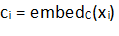

In [41]:
# embed the input into a sequence of vectors of size query_maxlen<input encoder c>(C)
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))
# output: (samples, story_maxlen, query_maxlen)

It starts with query being converted into a word embedding of size k. As a part of this process, the query q is first converted into a vector of size V (V is the size of vocabulary used). e.g. 
Following is the vector for the query “where is the milk” (after parsing):
    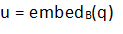
    
Then, using a bag of word model or embedding B(k × V), the vector is converted into a word embedding of size k. Let the vector be finally called u(size k).u is the interbal state
    


In [42]:
# embed the question into a sequence of vectors(B)
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,#want to match with inputs encoder m
                               input_length=max_question_len))#specifically for question 
question_encoder.add(Dropout(0.3))
# output: (samples, query_maxlen, embedding_dim)

In [43]:
#Encode the Sequences.ENCODED<----ENCODER(INPUT)
# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

We take the inner product between query and each memory vector, followed by softmax operation, to find the best match
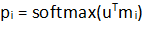
At this stage, we have found out the most relevant sentence for the query. e.g. if the query was “where is the milk”, based on the calculated probability vector, relevant sentence that was found is “Mary got the milk”.

In [47]:
# shape: `(samples, story_maxlen, query_maxlen)`
#Use dot product to compute the match between first input vector seq and the query
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

Using the probability vector from previous part, we will compute the output as follows
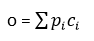
For easier interpretation, we took the query and relevant sentence found before(i.e. Combination of “where is the milk” and “Mary got the milk”), as the new query for evaluation. Using this new query, and each of the sentence again as memory vectors, we tried to infer the answer from the context of the story. 

Permute layer of keras
Permutes the dimensions of the input according to a given pattern.
Permutation pattern does not include the samples dimension. Indexing starts at 1. 
For instance, (2, 1) permutes the first and second dimensions of the input


In [48]:
# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)

In [49]:
# concatenate the match matrix with the question vector sequence
answer = concatenate([response, question_encoded])

In [50]:
answer

<tf.Tensor 'concatenate/Identity:0' shape=(None, 6, 220) dtype=float32>

In [51]:
answer=LSTM(32)(answer)

In [52]:
# Regularization with Dropout
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)

Finally, prediction of output is obtained with the help of matrix W (V × d) through the following equation.
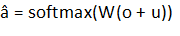
Actually this model will predict probablility for each  word in vocabulary but realatively higher probability for YES and NO.

In [55]:
# we output a probability distribution over the vocabulary

answer = Activation('softmax')(answer)

# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [56]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 156)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       multiple             2432        input_7[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 6, 64)        2432        input_8[0][0]                    
____________________________________________________________________________________________

In [83]:
# train
history = model.fit([inputs_train, queries_train], answers_train,batch_size=32,epochs=20,validation_data=([inputs_test, queries_test], answers_test))

Train on 10000 samples, validate on 1000 samples
Epoch 1/20
10000/10000 [==============================] - 7s 653us/sample - loss: 3.1861 - accuracy: 0.4961 - val_loss: 3.1848 - val_accuracy: 0.4970
Epoch 2/20
10000/10000 [==============================] - 7s 656us/sample - loss: 3.1806 - accuracy: 0.5012 - val_loss: 3.1848 - val_accuracy: 0.4970
Epoch 3/20
10000/10000 [==============================] - 6s 647us/sample - loss: 3.1806 - accuracy: 0.5012 - val_loss: 3.1848 - val_accuracy: 0.4970
Epoch 4/20
10000/10000 [==============================] - 7s 692us/sample - loss: 3.1806 - accuracy: 0.5012 - val_loss: 3.1848 - val_accuracy: 0.4970
Epoch 5/20
10000/10000 [==============================] - 7s 704us/sample - loss: 3.1806 - accuracy: 0.5012 - val_loss: 3.1848 - val_accuracy: 0.4970
Epoch 6/20
10000/10000 [==============================] - 7s 659us/sample - loss: 3.1806 - accuracy: 0.5012 - val_loss: 3.1848 - val_accuracy: 0.4970
Epoch 7/20
10000/10000 [===========================

In [85]:
#Saving the Model
filename = 'QA_Bot.h5'
model.save(filename)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


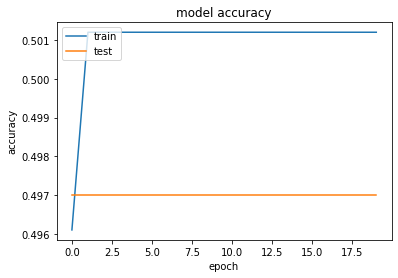

In [94]:
#Evaluating the model
#plotting our train history
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#practically both curves should start from low accuracy and as epoch are increased , the accuracy should be increasing.
#Train for more number of epochs

In [87]:
#Evaluatig on test set
#filename='chatbot_120_epochs.h5'#laoding the weights from already trained model
model.load_weights(filename)
pred_results = model.predict(([inputs_test, queries_test]))

In [88]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])#to find the index for max probability

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  yes
Probability of certainty was:  0.06843902


In [92]:
#Create our own stories
#select words from vocabulary
my_story='mary grabbed milk'#some story
my_question='mary grabbed milk'#some query
mydata = [(my_story.split(),my_question.split(),'yes')]
my_story,my_ques,my_ans = vectorize_stories(mydata)
pred_results = model.predict(([ my_story, my_ques]))

In [93]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  yes
Probability of certainty was:  0.06843902
